    This file is a part of the lor_neuro_rat project.
    Copyright (C) 2019 anonimous

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

    Please contact with me by E-mail: shkolnick.kun@gmail.com

In [1]:
# libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import h5py

import matplotlib.pyplot as plt
np.random.seed(32)

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, f1_score, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import gc
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Conv1D, Embedding, SpatialDropout1D, concatenate, Flatten
from keras.layers import GRU, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Dropout
#from keras.layers import CuDNNLSTM, CuDNNGRU

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.callbacks import Callback
from keras import optimizers
from keras.layers import Lambda

import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords

import os
#os.environ['OMP_NUM_THREADS'] = '4'

#from unidecode import unidecode

import time
%matplotlib inline

Using TensorFlow backend.


# Сформируем датасет

In [2]:
df = pd.read_pickle('data/XyWrdTok1с.pkl')

                         TopId             MsgId                      Creator  \
0        /forum/talks/12648516  comment-12649855      /people/mandala/profile   
1        /forum/talks/10056125  comment-10056157        /people/dvrts/profile   
2        /forum/talks/11903900  comment-11904141   /people/kiverattes/profile   
3        /forum/talks/12103367  comment-12103408   /people/alexferman/profile   
4  /forum/development/10968185  comment-10968212  /people/Progressive/profile   

                            Time                             SrcLink  \
0  2016-06-07T20:01:40.393+03:00  /forum/talks/12648516?cid=12649823   
1  2014-01-15T14:47:38.711+04:00                                       
2  2015-08-29T22:59:17.271+03:00  /forum/talks/11903900?cid=11904067   
3  2015-11-12T08:57:55.115+03:00  /forum/talks/12103367?cid=12103402   
4  2014-10-24T20:08:29.646+04:00                                       

                                           DelReason  \
0  Сообщение удалено по 

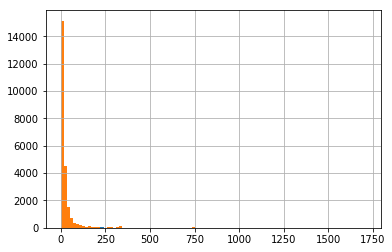

In [3]:
print(df.head())
print(df.describe())
df['TokCnt'].hist(bins=100)
df['WrdCnt'].hist(bins=100)

# Подготовка имбеддингов

In [4]:
y = df['Use'].values
X = [' '.join(tokens) for tokens in list(df['Tokens'])]

In [5]:
print(X[0])
print(X[1000])
print(y[0])
print(y[15000])

уровень развитие цивилизация лишь мы смотреть потомок крутить палец висок иметь значение этот ерунда вопрос страшно жить восклицание
мартышка зарабатывать корма тестирование мочь высказывать мнение
1
0


In [6]:
#Приделываем токенайзер из keras
max_features = 20000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X)
print(len(tokenizer.word_index))

45748


In [7]:
wrds = []
idxs = []
for w, i in tokenizer.word_index.items():
    wrds.append(w)
    idxs.append(i)
    
if 'рашка' in wrds:
    print(idxs[wrds.index('рашка')])

1743


In [8]:
#Сохраняем токенайзер
with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
#Грузим токенайзер
with open('models/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [10]:
max_len = 150
X_seq = tokenizer.texts_to_sequences(X)
X_seq_pad = pad_sequences(X_seq, maxlen=max_len)

In [11]:
h5f = h5py.File('data/Xy.h5', 'w')
print(h5f.create_dataset('X_seq_pad', data=X_seq_pad))
print(h5f.create_dataset('y', data=y))
h5f.close()

<HDF5 dataset "X_seq_pad": shape (23556, 150), type "<i4">
<HDF5 dataset "y": shape (23556,), type "<i8">


In [12]:
h5f = h5py.File('data/Xy.h5', 'r')
X_seq_pad = h5f['X_seq_pad'][:]
y         = h5f['y'][:]
h5f.close()
print(X_seq_pad.shape)
print(y.shape)

(23556, 150)
(23556,)


In [13]:
#Вычисляем матрицу весов слоя имбеддингов
from pymagnitude import *
import gensim

mg = Magnitude('Vectors/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.magnitude')
ft = gensim.models.fasttext.FastText.load('Vectors/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model')

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index)+1)
embedding_matrix = np.zeros((nb_words,300))

for word, i in word_index.items():
    #
    if i >= max_features: 
        continue
    #
    #embedding_matrix[i] = mg.query(word)
    try:
        embedding_matrix[i] = ft.wv[word]
    except:
        embedding_matrix[i] = mg.query(word)
    

In [14]:
#Сохраняем матрицу имбеддингов
h5f = h5py.File('models/EmbeddingMtx.h5', 'w')
print(h5f.create_dataset('EmbeddingMtx', data=embedding_matrix))
h5f.close()

<HDF5 dataset "EmbeddingMtx": shape (20000, 300), type "<f8">


In [15]:
#Грузим матрицу имбеддингов
h5f = h5py.File('models/EmbeddingMtx.h5', 'r')
embedding_matrix = h5f['EmbeddingMtx'][:]
h5f.close()

In [16]:
print(mg.most_similar(embedding_matrix[41]))

[('писать', 2.7740248044537354), ('написать', 2.3093317386643784), ('писаться', 1.9480354263493773), ('аписать', 1.924823287961308), ('пописывать', 1.9049477046842551), ('написаный', 1.8314904320010685), ('сочинять', 1.8245514440178163), ('читывать', 1.8131628951666887), ('строчить', 1.8044062893396267), ('цитировать', 1.7813154529572686)]


In [17]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1, cv_iter=0, arch=0):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val, self.Weigths = validation_data
        self.max_score = 0
        self.not_better_count = 0
        self._cv_iter = cv_iter
        self._arch = arch

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=1, batch_size=512)
            score = roc_auc_score(self.y_val, y_pred, sample_weight=self.Weigths)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
            if (score > self.max_score):
                print("*** New High Score (previous: %.6f) \n" % self.max_score)
                model.save("models/best_model_%d_%d.h5"%(int(self._arch),int(self._cv_iter)))
                self.max_score=score
                self.not_better_count = 0
            else:
                self.not_better_count += 1
                if self.not_better_count > 5:
                    print("Epoch %05d: early stopping, high score = %.6f" % (epoch,self.max_score))
                    self.model.stop_training = True

In [18]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 0
nn_arch = 0
def get_model(clipvalue=1.,num_filters=16,dropout=0.1,embed_size=300):
    inp = Input(shape=(None, ))
    
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = SpatialDropout1D(dropout)(x)
    
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True))(x)  
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_h, x_c, max_pool])
    
    x = Dropout(dropout)(x)
    
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue,lr=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [26]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 1
nn_arch = 1
def get_model(clipvalue=1.,num_filters=16,dropout=0.1,embed_size=300):
    inp = Input(shape=(None, ))
    
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    x = SpatialDropout1D(dropout)(x)
    
    # Тут мы получаем конкатенацию LSTM по двум направлениям 
    # плюс Hidden state и Cell state по двум направлениям
    x, x_a, x_b, x_c, x_d = Bidirectional(LSTM(num_filters, return_sequences=True, return_state = True))(x)  
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_a, x_b, x_c, x_d, max_pool])
    
    x = Dropout(dropout)(x)
    
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [28]:
#Взято отсюда: https://www.kaggle.com/larryfreeman/toxic-comments-code-for-alexander-s-9872-model
#Model 2
nn_arch = 3
def get_model(clipvalue=1.,num_filters=16,dropout=0.2,embed_size=300):
    inp = Input(shape=(None, ))
    
    # Layer 1: concatenated fasttext and glove twitter embeddings.
    x = Embedding(nb_words, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    
    # Uncomment for best result
    # Layer 2: SpatialDropout1D(0.5)
    x = SpatialDropout1D(dropout)(x)
    
    # Uncomment for best result
    # Layer 3: Bidirectional CuDNNLSTM
    x = Bidirectional(LSTM(num_filters, return_sequences=True))(x)


    # Layer 4: Bidirectional CuDNNGRU
    x, x_h, x_c = Bidirectional(GRU(num_filters, return_sequences=True, return_state = True))(x)  
    
    # Layer 5: A concatenation of the last state, maximum pool, average pool and 
    # two features: "Unique words rate" and "Rate of all-caps words"
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    x = concatenate([avg_pool, x_h, x_c, max_pool])
    
    x = Dropout(dropout)(x)
    
    # Layer 6: output dense layer.
    outp = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inp, outputs=outp)
    adam = optimizers.adam(clipvalue=clipvalue)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  weighted_metrics=['accuracy'])
    return model

In [19]:
print('Model:' , nn_arch)
#model = get_model()

batch_size = 1024

# Used epochs=100 with early exiting for best score.
epochs = 100
gc.collect()
K.clear_session()

# Change to 4
num_folds = 5 #number of folds

#Приводим типы
y = np.array(y)

#Веса примеров, "меняем местами" 1 и 0
w_0 = 1/np.sum((y == 0.0).astype('float'))
w_1 = 1.0/np.sum((y == 1.0).astype('float'))
w = w_0*(y == 0.0).astype('float') + w_1*(y == 1.0).astype('float')
w /= np.sum(w)
w *= len(y)

kf = KFold(n_splits=num_folds, shuffle=True)

i = 0
for train_index, test_index in kf.split(X):
    
    gc.collect()
    K.clear_session()
    
    y_train = y[train_index] 
    y_test  = y[test_index]
    
    X_train = X_seq_pad[train_index]
    X_test  = X_seq_pad[test_index]
    
    w_train = w[train_index]
    w_test  = w[test_index]
    
    model = get_model()
    
    ra_val = RocAucEvaluation(validation_data=(X_test, y_test, w_test), interval = 1, cv_iter=i, arch=nn_arch)
    
    model.fit(X_train, y_train, sample_weight=w_train, batch_size=batch_size, epochs=epochs, verbose=1,
             callbacks = [ra_val])
    
    y_t = load_model("models/best_model_%d_%d.h5"%(int(nn_arch),int(i))).predict(X_test, verbose=1, batch_size=512)
    y_a = (y_t>0.5).astype('float').reshape(y_test.shape)
    
    print('Weighted scores')
    print(' *    Acc:', accuracy_score(y_test, y_a, sample_weight=w_test))
    print(' *   Prec:', precision_score(y_test, y_a, sample_weight=w_test))
    print(' * Recall:', recall_score(y_test, y_a, sample_weight=w_test))
    print(' *     F1:', f1_score(y_test, y_a, sample_weight=w_test))
    print(' * RocAuc:', roc_auc_score(y_test, y_t, sample_weight=w_test))

    print('Scores')
    print(' *    Acc:', accuracy_score(y_test, y_a))
    print(' *   Prec:', precision_score(y_test, y_a))
    print(' * Recall:', recall_score(y_test, y_a))
    print(' *     F1:', f1_score(y_test, y_a))
    print(' * RocAuc:', roc_auc_score(y_test, y_t))

    print('================')
    print('FP:', np.sum((y_a != y_test).astype('float')*y_a))
    print('FN:', np.sum((y_a != y_test).astype('float')*y_test))
    print('TP:', np.sum((y_a == y_test).astype('float')*y_a))
    print('TN:', np.sum((y_a == y_test).astype('float')*(1-y_test)))
    
    gc.collect()
    
    i += 1

print("Done")

Model: 0
Epoch 1/100
4712/4712 [==============================] - 1s 161us/step

 ROC-AUC - epoch: 1 - score: 0.739337 

*** New High Score (previous: 0.000000) 

Epoch 2/100
4712/4712 [==============================] - 1s 165us/step

 ROC-AUC - epoch: 2 - score: 0.769451 

*** New High Score (previous: 0.739337) 

Epoch 3/100
4712/4712 [==============================] - 1s 134us/step

 ROC-AUC - epoch: 3 - score: 0.801630 

*** New High Score (previous: 0.769451) 

Epoch 4/100
4712/4712 [==============================] - 1s 131us/step

 ROC-AUC - epoch: 4 - score: 0.826454 

*** New High Score (previous: 0.801630) 

Epoch 5/100
4712/4712 [==============================] - 1s 141us/step

 ROC-AUC - epoch: 5 - score: 0.838689 

*** New High Score (previous: 0.826454) 

Epoch 6/100
4712/4712 [==============================] - 1s 135us/step

 ROC-AUC - epoch: 6 - score: 0.844625 

*** New High Score (previous: 0.838689) 

Epoch 7/100
4712/4712 [==============================] - 1s 129us/s

4712/4712 [==============================] - 1s 147us/step

 ROC-AUC - epoch: 33 - score: 0.878312 

*** New High Score (previous: 0.877939) 

Epoch 34/100
4712/4712 [==============================] - 1s 136us/step

 ROC-AUC - epoch: 34 - score: 0.878711 

*** New High Score (previous: 0.878312) 

Epoch 35/100
4712/4712 [==============================] - 1s 146us/step

 ROC-AUC - epoch: 35 - score: 0.879355 

*** New High Score (previous: 0.878711) 

Epoch 36/100
4712/4712 [==============================] - 1s 136us/step

 ROC-AUC - epoch: 36 - score: 0.879337 

Epoch 37/100
4712/4712 [==============================] - 1s 130us/step

 ROC-AUC - epoch: 37 - score: 0.879972 

*** New High Score (previous: 0.879355) 

Epoch 38/100
4712/4712 [==============================] - 1s 135us/step

 ROC-AUC - epoch: 38 - score: 0.878992 

Epoch 39/100
4712/4712 [==============================] - 1s 148us/step

 ROC-AUC - epoch: 39 - score: 0.879449 

Epoch 40/100
4712/4712 [=======================

4711/4711 [==============================] - 1s 137us/step

 ROC-AUC - epoch: 10 - score: 0.872035 

*** New High Score (previous: 0.869259) 

Epoch 11/100
4711/4711 [==============================] - 1s 130us/step

 ROC-AUC - epoch: 11 - score: 0.873353 

*** New High Score (previous: 0.872035) 

Epoch 12/100
4711/4711 [==============================] - 1s 131us/step

 ROC-AUC - epoch: 12 - score: 0.874431 

*** New High Score (previous: 0.873353) 

Epoch 13/100
4711/4711 [==============================] - 1s 136us/step

 ROC-AUC - epoch: 13 - score: 0.876777 

*** New High Score (previous: 0.874431) 

Epoch 14/100
4711/4711 [==============================] - 1s 131us/step

 ROC-AUC - epoch: 14 - score: 0.877828 

*** New High Score (previous: 0.876777) 

Epoch 15/100
4711/4711 [==============================] - 1s 135us/step

 ROC-AUC - epoch: 15 - score: 0.879146 

*** New High Score (previous: 0.877828) 

Epoch 16/100
4711/4711 [==============================] - 1s 134us/step

 ROC

4711/4711 [==============================] - 1s 131us/step

 ROC-AUC - epoch: 43 - score: 0.890140 

Epoch 44/100
4711/4711 [==============================] - 1s 131us/step

 ROC-AUC - epoch: 44 - score: 0.889005 

Epoch 45/100
4711/4711 [==============================] - 1s 132us/step

 ROC-AUC - epoch: 45 - score: 0.890675 

Epoch 46/100
4711/4711 [==============================] - 1s 142us/step

 ROC-AUC - epoch: 46 - score: 0.890636 

Epoch 47/100
4711/4711 [==============================] - 1s 145us/step

 ROC-AUC - epoch: 47 - score: 0.890575 

Epoch 00046: early stopping, high score = 0.891137
4711/4711 [==============================] - 1s 174us/step
Weighted scores
 *    Acc: 0.8098068350668648
 *   Prec: 0.8228545204222121
 * Recall: 0.7785497177594441
 *     F1: 0.8000892458723783
 * RocAuc: 0.8911367773942122
Scores
 *    Acc: 0.8098068350668648
 *   Prec: 0.8228545204222121
 * Recall: 0.7785497177594441
 *     F1: 0.8000892458723783
 * RocAuc: 0.8911367773942122
FP: 386.0


4711/4711 [==============================] - 1s 133us/step

 ROC-AUC - epoch: 28 - score: 0.880470 

*** New High Score (previous: 0.879845) 

Epoch 29/100
4711/4711 [==============================] - 1s 134us/step

 ROC-AUC - epoch: 29 - score: 0.880410 

Epoch 30/100
4711/4711 [==============================] - 1s 145us/step

 ROC-AUC - epoch: 30 - score: 0.880370 

Epoch 31/100
4711/4711 [==============================] - 1s 135us/step

 ROC-AUC - epoch: 31 - score: 0.881781 

*** New High Score (previous: 0.880470) 

Epoch 32/100
4711/4711 [==============================] - 1s 132us/step

 ROC-AUC - epoch: 32 - score: 0.879217 

Epoch 33/100
4711/4711 [==============================] - 1s 150us/step

 ROC-AUC - epoch: 33 - score: 0.881495 

Epoch 34/100
4711/4711 [==============================] - 1s 135us/step

 ROC-AUC - epoch: 34 - score: 0.880869 

Epoch 35/100
4711/4711 [==============================] - 1s 170us/step

 ROC-AUC - epoch: 35 - score: 0.880739 

Epoch 36/100
4711

4711/4711 [==============================] - 1s 132us/step

 ROC-AUC - epoch: 8 - score: 0.860272 

*** New High Score (previous: 0.856813) 

Epoch 9/100
4711/4711 [==============================] - 1s 138us/step

 ROC-AUC - epoch: 9 - score: 0.862690 

*** New High Score (previous: 0.860272) 

Epoch 10/100
4711/4711 [==============================] - 1s 132us/step

 ROC-AUC - epoch: 10 - score: 0.865270 

*** New High Score (previous: 0.862690) 

Epoch 11/100
4711/4711 [==============================] - 1s 133us/step

 ROC-AUC - epoch: 11 - score: 0.866250 

*** New High Score (previous: 0.865270) 

Epoch 12/100
4711/4711 [==============================] - 1s 132us/step

 ROC-AUC - epoch: 12 - score: 0.867881 

*** New High Score (previous: 0.866250) 

Epoch 13/100
4711/4711 [==============================] - 1s 131us/step

 ROC-AUC - epoch: 13 - score: 0.869479 

*** New High Score (previous: 0.867881) 

Epoch 14/100
4711/4711 [==============================] - 1s 173us/step

 ROC-AU

4711/4711 [==============================] - 1s 133us/step

 ROC-AUC - epoch: 42 - score: 0.880814 

Epoch 43/100
4711/4711 [==============================] - 1s 136us/step

 ROC-AUC - epoch: 43 - score: 0.881937 

Epoch 44/100
4711/4711 [==============================] - 1s 131us/step

 ROC-AUC - epoch: 44 - score: 0.882514 

*** New High Score (previous: 0.882227) 

Epoch 45/100
4711/4711 [==============================] - 1s 135us/step

 ROC-AUC - epoch: 45 - score: 0.882023 

Epoch 46/100
4711/4711 [==============================] - 1s 140us/step

 ROC-AUC - epoch: 46 - score: 0.881603 

Epoch 47/100
4711/4711 [==============================] - 1s 135us/step

 ROC-AUC - epoch: 47 - score: 0.878881 

Epoch 48/100
4711/4711 [==============================] - 1s 133us/step

 ROC-AUC - epoch: 48 - score: 0.880583 

Epoch 49/100
4711/4711 [==============================] - 1s 134us/step

 ROC-AUC - epoch: 49 - score: 0.880894 

Epoch 50/100
4711/4711 [==============================] - 1

Epoch 24/100
4711/4711 [==============================] - 1s 133us/step

 ROC-AUC - epoch: 24 - score: 0.869078 

*** New High Score (previous: 0.868413) 

Epoch 25/100
4711/4711 [==============================] - 1s 133us/step

 ROC-AUC - epoch: 25 - score: 0.869532 

*** New High Score (previous: 0.869078) 

Epoch 26/100
4711/4711 [==============================] - 1s 135us/step

 ROC-AUC - epoch: 26 - score: 0.869547 

*** New High Score (previous: 0.869532) 

Epoch 27/100
4711/4711 [==============================] - 1s 132us/step

 ROC-AUC - epoch: 27 - score: 0.869083 

Epoch 28/100
4711/4711 [==============================] - 1s 136us/step

 ROC-AUC - epoch: 28 - score: 0.871020 

*** New High Score (previous: 0.869547) 

Epoch 29/100
4711/4711 [==============================] - 1s 133us/step

 ROC-AUC - epoch: 29 - score: 0.871125 

*** New High Score (previous: 0.871020) 

Epoch 30/100
4711/4711 [==============================] - 1s 133us/step

 ROC-AUC - epoch: 30 - score: 0.8

# Типичные метрики на кросс-валидации
По разым значениям соотношения TP/TN в датасете

Самая удачная модель - 0

## 1/1

Weighted scores
 *    Acc: 0.8083041251011054
 *   Prec: 0.82168409466153
 * Recall: 0.7941489361702128
 *     F1: 0.8076819042466866
 * RocAuc: 0.8898640985074974

Scores
 *    Acc: 0.8083041251011054
 *   Prec: 0.82168409466153
 * Recall: 0.7941489361702128
 *     F1: 0.8076819042466866
 * RocAuc: 0.8898640985074974

## 1/2

Weighted scores
 *    Acc: 0.8088235294117647
 *   Prec: 0.8343594253884491
 * Recall: 0.7696051919956733
 *     F1: 0.8006752004501336
 * RocAuc: 0.8905964539186791

Scores
 *    Acc: 0.8218587093294984
 *   Prec: 0.71579476861167
 * Recall: 0.7696051919956733
 *     F1: 0.7417253062288245
 * RocAuc: 0.8905964539186791

## 1/5

Weighted scores
 *    Acc: 0.8105686695278971
 *   Prec: 0.8398097668483119
 * Recall: 0.7710330138445154
 *     F1: 0.8039531397478944
 * RocAuc: 0.891488846674163
 
Scores
 *    Acc: 0.8372573687994249
 *   Prec: 0.511841640155532
 * Recall: 0.7710330138445154
 *     F1: 0.615253877204164
 * RocAuc: 0.8914888466741502

## Все данные

In [23]:
#y_all = load_model('models/best_model_0_0.h5').predict(X_seq_pad, verbose=1, batch_size=512)
#y_all += load_model('models/best_model_0_1.h5').predict(X_seq_pad, verbose=1, batch_size=512)
#y_all += load_model('models/best_model_0_2.h5').predict(X_seq_pad, verbose=1, batch_size=512)
#y_all += load_model('models/best_model_0_3.h5').predict(X_seq_pad, verbose=1, batch_size=512)
#y_all += load_model('models/best_model_0_4.h5').predict(X_seq_pad, verbose=1, batch_size=512)
#y_all /= 5.0#2.0*np.average(y_all)

23556/23556 [==============================] - 4s 155us/step


In [24]:
#y_t = (y_all>1.0*np.average(y_all)).astype('float').reshape(y.shape)
y_t = (y_all>0.8).astype('float').reshape(y.shape)

#print('==== Weghtted scores ====')
#print('   Acc:', accuracy_score(y, y_t, sample_weight=w))
#print('  Prec:', precision_score(y, y_t, sample_weight=w))
#print('Recall:', recall_score(y, y_t, sample_weight=w))
#print('    F1:', f1_score(y, y_t, sample_weight=w))
#print('RocAuc:', roc_auc_score(y, y_t, sample_weight=w))

print('==== Scores ====')
print('   Acc:', accuracy_score(y, y_t))
print('  Prec:', precision_score(y, y_t))
print('Recall:', recall_score(y, y_t))
print('    F1:', f1_score(y, y_t))
print('RocAuc:', roc_auc_score(y, y_all))

print('================')
print('FP:', np.sum((y_t != y).astype('float')*y_t))
print('FN:', np.sum((y_t != y).astype('float')*y))
print('TP:', np.sum((y_t == y).astype('float')*y_t))
print('TN:', np.sum((y_t == y).astype('float')*(1-y)))
print('N: ', len(X))

==== Scores ====
   Acc: 0.7912209203599933
  Prec: 0.9673024523160763
Recall: 0.6028188147393445
    F1: 0.742755518359661
RocAuc: 0.9330113863421275
FP: 240.0
FN: 4678.0
TP: 7100.0
TN: 11538.0
N:  23556


In [67]:
df.describe()

,Score,Class,Use,WrdCnt,TokCnt
count,102003.000000,102003.000000,102003.000000,102003.000000,102003.000000
mean,-0.278511,0.416654,0.090909,21.891670,21.803937
std,1.291645,1.530255,0.287481,35.356617,35.295298
min,-20.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,6.000000,6.000000
50%,0.000000,0.000000,0.000000,13.000000,12.000000
75%,0.000000,0.000000,0.000000,25.000000,25.000000
max,0.000000,16.000000,1.000000,1113.000000,1113.000000


In [68]:
df['FN'] = y*(y_t != y).astype('float')
df['FP'] = y_t*(y_t != y).astype('float')

In [69]:
df_fp = df[df['FP'] == 1.0]

In [70]:
df_fp.describe()

,Score,Class,Use,WrdCnt,TokCnt,FN,FP
count,19454.0,19454.0,19454.0,19454.000000,19454.000000,19454.0,19454.0
mean,0.0,0.0,0.0,22.460728,22.339365,0.0,1.0
std,0.0,0.0,0.0,31.955747,31.755524,0.0,0.0
min,0.0,0.0,0.0,0.000000,1.000000,0.0,1.0
25%,0.0,0.0,0.0,7.000000,7.000000,0.0,1.0
50%,0.0,0.0,0.0,13.000000,13.000000,0.0,1.0
75%,0.0,0.0,0.0,25.000000,25.000000,0.0,1.0
max,0.0,0.0,0.0,741.000000,732.000000,0.0,1.0


In [71]:
df_fp.to_pickle('data/Xy_fp.pkl')
df_fp.to_excel('data/Xy_fp.xlsx')

In [72]:
df_fn = df[df['FN'] == 1.0]

In [73]:
df_fn.to_pickle('data/Xy_fn.pkl')
df_fn.to_excel('data/Xy_fn.xlsx')